# DBSCAN

DBSCAN(Density-Based Spatial Clustering of Applications with Noise)
밀도 기반 군집화 알고리즘
데이터가 많이 몰려 있는 곳은 군집, 고립된 데이터는 이상치로 구분한다


eps : 반경 거리/ 이 거리 안에 몇 개의 데이터가 있는지 확인
min_samples : eps 안에 있어야 하는 최소 데이터 수. 이 이상이면 군집으로 간주
core point : eps 반경 내에 min_samples 이상 있는 데이터 포인트
border point : core 는 아니지만 core 근처에 붙어 있는 데이터
noise point : 아무 군집에도 포함되지 못한 고립된 데이터 (-1번 군집)


1. 모든 데이터를 하나씩 훑으며 시작
2. 어떤 점의 eps 반경 내에 min_samples 이상 이웃이 있으면 -> 군집 생성 시작
3. 이웃 중 core point 를 계속 찾아서 군집 확장
4. core가 아닌 border point 는 군집 끝에 포함
5. 조건 안 맞는 점은 noise로 간주

군집을 k-means 처럼 수를 미리 설정하지 않아도 된다
다양한 모양으로 군집형성
이상치 탐지 가능
밀도 차이에 민감 -> 밀도가 크게 다르면 성능이 떨어질 수 있다.(결과를 보고 이상하면 HDBSCAN 사용 -> DBSCAN의 고급 버전 각 영역의 밀도에 맞게 동적으로 군집 결정 가능)


이상치를 왜 필요한가? 군집으로 묶기 애매(추천하기 어려운 곳 - 시설도 없고 아이도 없고 완전 외곽)한 곳들을 걸러준다

In [3]:
import pandas as pd

# Numbers → CSV로 변환한 파일 불러오기
file_path = '행정동단위통합_최종병합.csv'

# 컬럼 수동 지정
columns = [
    '행정동명',
    '총인구수',
    '0~4세',
    '5~9세',
    '0~9세',
    '세대당인구',
    '실내놀이터+키즈카페',
    '주변_키즈카페_포함',
    '소득분위',
    '가구수',
    '혼잡빈도강도_평일',
    '혼잡시간강도_평일',
    '서울형키즈카페',
    '주변_서울형키즈카페'
]

# 첫 행 건너뛰고 불러오기
df = pd.read_csv(file_path, skiprows=1, names=columns)

In [6]:
# 사용할 수치형 feature 열만 선택
features = [
    '총인구수',
    '0~4세',
    '5~9세',
    '0~9세',
    '세대당인구',
    '실내놀이터+키즈카페',
    '주변_키즈카페_포함',
    '소득분위',
    '가구수',
    '혼잡빈도강도_평일',
    '혼잡시간강도_평일',
    '서울형키즈카페',
    '주변_서울형키즈카페'
]

# 숫자형으로 변환 + 결측치 제거
df_features = df[features].apply(pd.to_numeric, errors='coerce').dropna()
행정동 = df.loc[df_features.index, '행정동명'].reset_index(drop=True)
df_features.reset_index(drop=True, inplace=True)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

esp 정하기

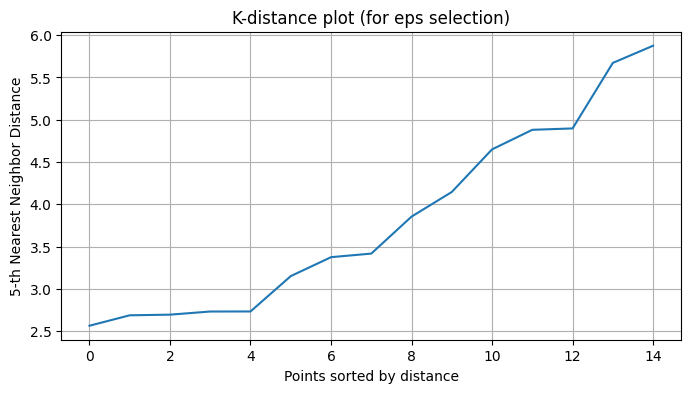

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# min_samples 값 (기본적으로 5~10 정도 추천)
min_samples = 5

# 거리 계산
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# 각 포인트에서 min_samples번째로 가까운 거리
k_distances = np.sort(distances[:, -1])

# 플롯 그리기
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("K-distance plot (for eps selection)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

2.7로 결정

In [15]:
from sklearn.cluster import DBSCAN

# eps는 거리 기준, min_samples는 최소 이웃 수
dbscan = DBSCAN(eps=2.7, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# 결과 저장
df_result = df_features.copy()
df_result['cluster'] = labels
df_result['행정동'] = 행정동

In [16]:
print(df_result['cluster'].value_counts().sort_index())

# 군집별 평균값 보기
print(df_result.groupby('cluster').mean(numeric_only=True))

cluster
-1    7
 0    8
Name: count, dtype: int64
                 총인구수        0~4세        5~9세         0~9세     세대당인구  \
cluster                                                                
-1       22704.571429  446.285714  677.142857  1123.428571  2.044286   
 0       22077.750000  381.875000  493.000000   874.875000  1.936250   

         실내놀이터+키즈카페  주변_키즈카페_포함      소득분위           가구수  혼잡빈도강도_평일  혼잡시간강도_평일  \
cluster                                                                         
-1         1.428571    2.285714  6.857143  11346.571429  71.285714  82.428571   
 0         0.875000    2.625000  6.125000  11284.625000  79.125000  87.875000   

          서울형키즈카페  주변_서울형키즈카페  
cluster                        
-1       0.428571    1.285714  
 0       0.000000    0.125000  


서울형키즈카페가 없는것이 우선인데 0 클러스터가 일단 서울형이 없고  소득분위도 낮다. 0~9세 인구는 적지만 그만큼 실내놀이터+키즈카페 수도 낮아서 0번 결정


In [17]:
# 0번 클러스터에 속한 데이터만 추출해서 출력
cluster_0 = df_result[df_result['cluster'] == 0]
print("✅ 클러스터 0번에 속한 데이터:")
print(cluster_0)

✅ 클러스터 0번에 속한 데이터:
     총인구수  0~4세  5~9세  0~9세  세대당인구  실내놀이터+키즈카페  주변_키즈카페_포함  소득분위      가구수  \
0   15239   264   256   520   1.76           1           3   6.0   8644.0   
1   20521   302   489   791   1.94           1           4   6.0  10569.0   
3   27594   454   525   979   2.11           1           2   6.0  13022.0   
5   23127   365   467   832   1.77           0           4   6.0  12519.0   
6   25610   528   772  1300   2.23           2           3   6.0  11380.0   
9   21833   293   398   691   1.82           1           2   6.0  11960.0   
10  23628   531   641  1172   2.17           0           1   7.0  10890.0   
14  19070   318   396   714   1.69           1           2   6.0  11293.0   

    혼잡빈도강도_평일  혼잡시간강도_평일  서울형키즈카페  주변_서울형키즈카페  cluster   행정동  
0          82         89        0           0        0  중곡1동  
1          87         93        0           0        0  중곡2동  
3          71         84        0           1        0  중곡4동  
5          90         95        0  

0번 다시 클러스터링
DBSCAN

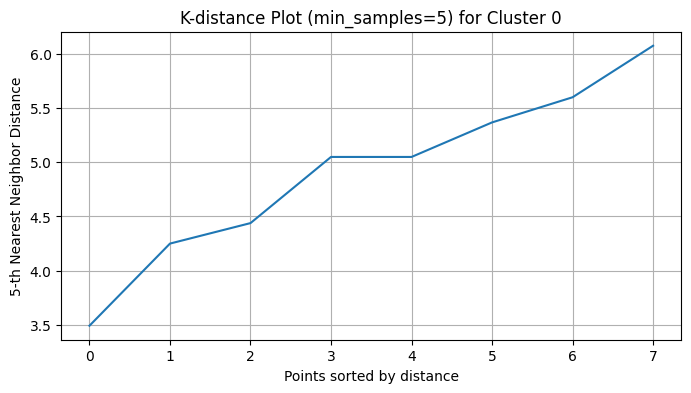

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. 클러스터 0번 추출
cluster_0 = df_result[df_result['cluster'] == 0].copy()

# 2. 사용할 피처 정의
features = [
    '총인구수',
    '0~4세',
    '5~9세',
    '0~9세',
    '세대당인구',
    '실내놀이터+키즈카페',
    '주변_키즈카페_포함',
    '소득분위',
    '가구수',
    '혼잡빈도강도_평일',
    '혼잡시간강도_평일',
    '서울형키즈카페',
    '주변_서울형키즈카페' 
]

# 3. 결측치 제거 + 정규화
cluster_0 = cluster_0.dropna(subset=features).copy()
scaler = StandardScaler()
X_scaled_0 = scaler.fit_transform(cluster_0[features])

# 4. K-distance plot 그리기
min_samples = 5  # 기본값 추천: 5~10
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_0)
distances, indices = neighbors_fit.kneighbors(X_scaled_0)

# 각 포인트의 min_samples번째 거리 (즉, eps 후보)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f'K-distance Plot (min_samples={min_samples}) for Cluster 0')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

In [19]:
# eps는 위 그래프를 보고 결정 (예: 1.2)
eps = 5.0

# DBSCAN 적용
db = DBSCAN(eps=eps, min_samples=min_samples)
cluster_0['sub_cluster'] = db.fit_predict(X_scaled_0)

# 결과 확인
print(cluster_0['sub_cluster'].value_counts().sort_index())

sub_cluster
-1    1
 0    7
Name: count, dtype: int64


명확한 군집이 안 나뉘므로 다른 알고리즘 사용 계층적 군집화

In [20]:
# 수치형 평균값 요약
print(cluster_0.groupby('sub_cluster').mean(numeric_only=True))

                     총인구수        0~4세        5~9세         0~9세     세대당인구  \
sub_cluster                                                                
-1           23628.000000  531.000000  641.000000  1172.000000  2.170000   
 0           21856.285714  360.571429  471.857143   832.428571  1.902857   

             실내놀이터+키즈카페  주변_키즈카페_포함  소득분위      가구수  혼잡빈도강도_평일  혼잡시간강도_평일  \
sub_cluster                                                                
-1                  0.0    1.000000   7.0  10890.0  70.000000  82.000000   
 0                  1.0    2.857143   6.0  11341.0  80.428571  88.714286   

             서울형키즈카페  주변_서울형키즈카페  cluster  
sub_cluster                                
-1               0.0    0.000000      0.0  
 0               0.0    0.142857      0.0  


In [21]:
from sklearn.cluster import AgglomerativeClustering

# 군집 수는 일단 2~4 사이로 테스트
agg = AgglomerativeClustering(n_clusters=3)
cluster_0['sub_cluster'] = agg.fit_predict(X_scaled_0)

# 결과 확인
print(cluster_0['sub_cluster'].value_counts().sort_index())

sub_cluster
0    5
1    2
2    1
Name: count, dtype: int64


시각화

/Users/kwon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kwon/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) m

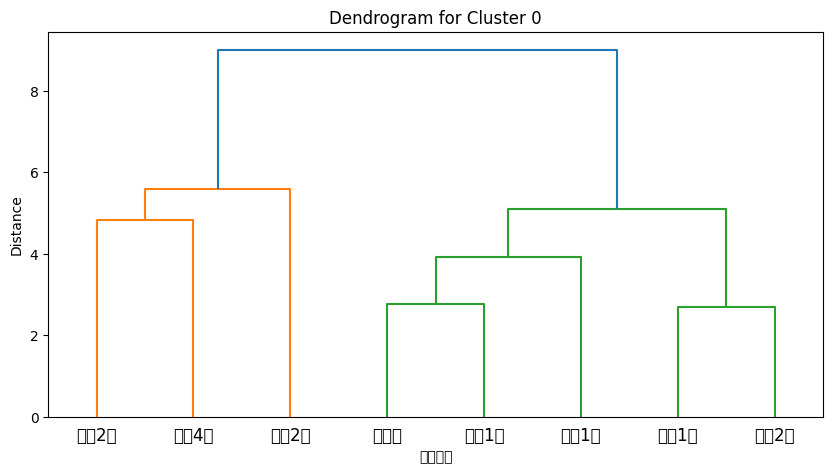

In [23]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# 연결행렬 계산
linked = linkage(X_scaled_0, method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=cluster_0['행정동'].values, orientation='top', distance_sort='descending')
plt.title('Dendrogram for Cluster 0')
plt.xlabel('행정동명')
plt.ylabel('Distance')
plt.show()

군집 수 3으로 결정

In [25]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
cluster_0['sub_cluster'] = agg.fit_predict(X_scaled_0)

# 결과 보기
print("✅ 하위 군집 결과:")
print(cluster_0[['행정동', 'sub_cluster']])

✅ 하위 군집 결과:
     행정동  sub_cluster
0   중곡1동            0
1   중곡2동            0
3   중곡4동            1
5   구의1동            0
6   구의2동            1
9   자양1동            0
10  자양2동            2
14   군자동            0


In [26]:
print("✅ 각 하위 군집의 특성 평균:")
print(cluster_0.groupby('sub_cluster').mean(numeric_only=True))

✅ 각 하위 군집의 특성 평균:
                총인구수   0~4세   5~9세    0~9세  세대당인구  실내놀이터+키즈카페  주변_키즈카페_포함  \
sub_cluster                                                                 
0            19958.0  308.4  401.2   709.6  1.796         0.8         3.0   
1            26602.0  491.0  648.5  1139.5  2.170         1.5         2.5   
2            23628.0  531.0  641.0  1172.0  2.170         0.0         1.0   

             소득분위      가구수  혼잡빈도강도_평일  혼잡시간강도_평일  서울형키즈카페  주변_서울형키즈카페  cluster  
sub_cluster                                                                     
0             6.0  10997.0       82.2       89.6      0.0         0.0      0.0  
1             6.0  12201.0       76.0       86.5      0.0         0.5      0.0  
2             7.0  10890.0       70.0       82.0      0.0         0.0      0.0  


2번 군집이 제일 좋아보임 2번 군집인 자양 2동으로 결정








